### 📘 Lesson 4: Introduction to GeoPandas

<div style="display: flex; align-items: center; justify-content: space-between;">
  <div>
    <h3>Notebook Developers</h3>
    <ul>
      <li><strong>Dr. Fabrizio Finozzi</strong> - Big Data Software Developer</li>
      <li><strong>Priyesh Gosai</strong> - Energy Systems Modeler and Training Coordinator</li>
    </ul>
  </div>
  <div>
    <a href="https://openenergytransition.org/index.html">
      <img src="https://openenergytransition.org/assets/img/oet-logo-red-n-subtitle.png" height="60" alt="OET">
    </a>
  </div>
</div>

##### 🎯 Learning Objectives  

* Understand the fundamentals of GeoPandas and its role in geospatial data analysis.
* Explore and analyze the core data structures used in GeoPandas for handling spatial data.
* Learn how to process, manipulate, and visualize geospatial information using GeoPandas.

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set FOLDER and change to the working directory in one step
FOLDER = 'ich-modeling-2025'
os.chdir(f'/content/drive/MyDrive/{FOLDER}')

# Confirm the current working directory
print("Current working directory:", os.getcwd())


### What is GeoPandas
---


GeoPandas extends the functionalities of Pandas to geospatial data, which is time-based data that is related to a location on the surface of Earth.

#### Data structure

The basic data structure provided by GeoPandas are `GeoSeries` and `GeoDataFrame`. A `GeoDataFrame` is a subclass of Pandas `DataFrame`, that can store geometry columns and perform spatial operations. The basic structure of `GeoDataFrame` is shown below


In [ ]:
from IPython.display import Image
Image("images/numpy_applications.png", width=500)

There are two main `models` (i.e. a simplified version of the represented objects) for storing geospatial data
- vector
- raster

#### Vector

A `vector` data model stores locations as discrete geometric objects. The ones available are shown in the image below taken from this [link](https://r-spatial.org/book/03-Geometries.html). For example, a `POINT()` is represented by a longitude and latitude coordinate pair, whereas a `POLYGON` is a set of `POINT()` that delimit a closed area.

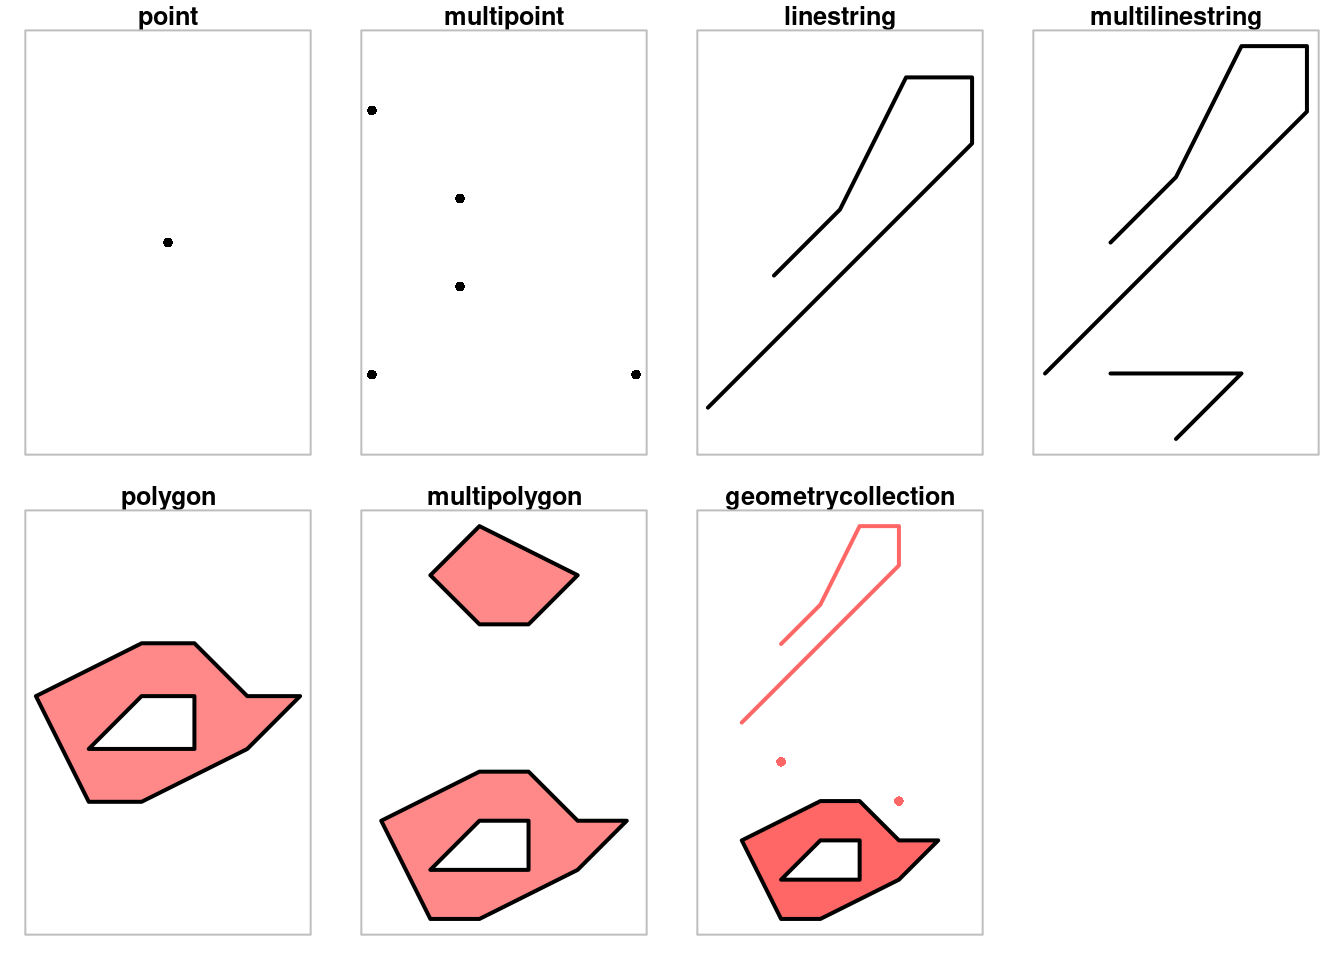

In [1]:
from IPython.display import Image
Image("images/geometry.png", width=500)

Areas are occasionally represented with a `centroid`, which is the point that is mathematically equidistant from all points of the area.

#### Raster

Raster data is instead stored on a grid of pixels. Each pixel encodes the necessary properties that characterize the given area, as elevation or temperature.

#### Working with geospatial information

Geospatial information are usually contained in files with format `GeoPackage`, `GeoJSON` or `Shapefile`. Such files can be read in with the command below. 

The command detects the filetype and reads the data into a `GeoDataFrame`. The file below contains the shapes of all countries taken from [Natural Earth](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/).


Natural Earth is a public domain map dataset available at 1:10m, 1:50m, and 1:110 million scales. Featuring tightly integrated vector and raster data, with Natural Earth you can make a variety of visually pleasing, well-crafted maps with cartography or GIS software.

### Mapping SAPP
---

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic


In [ ]:
# Load the shapefile
shape_file_path = pathlib.Path(pathlib.Path.cwd(), "shapes", "ne_110m_admin_0_countries.shp")
gdf = gpd.read_file(shape_file_path)


Lets look at the `gdf` object contains a variety of data for each country. 

In [ ]:
for i in range(len(gdf.columns)):
    print(f"{gdf.columns[i]}")

The `gdf` object is a dataframe containing a variety of data related to each country. 

* Population 
* GDP 
* ISO Code names 
* ... and many more.

We can see all the countries in Africa represented in the data set. 

In [ ]:
gdf[['NAME','POP_EST','GDP_MD','ISO_A2','CONTINENT']]

We can filter countries by any column.

In [ ]:
print(gdf[gdf["CONTINENT"] == "Africa"]["NAME"].unique())


Now lets look at Zimbabwe. 

In [ ]:
zw_gdf = gdf[gdf["NAME"] == "Zimbabwe"]

If we look at the geometry of Zimbabwe, we can see that it is a polygon with multiple parts.

In [ ]:
zw_gdf[["NAME", "geometry"]]

We can plot the geometry. 

In [ ]:
zw_gdf.plot()

We can also define a list of countries such as each power pool. 

In [ ]:
# Define SAPP countries
sapp_countries = [
    "Angolimport pandas as pda", "Botswana", "Democratic Republic of the Congo", "Eswatini", "Lesotho",
    "Malawi", "Mozambique", "Namibia", "South Africa", "Tanzania", "Zambia", "Zimbabwe"
]


In [ ]:
sapp_gdf = gdf[gdf['NAME'].isin(sapp_countries)]

We can plot the polygons. 

In [ ]:
sapp_gdf.plot(column="NAME", cmap="tab20", edgecolor="black", figsize=(10, 10))


Or color the countries by shape. 

In [ ]:
sapp_gdf.plot(column="POP_EST", cmap="OrRd", edgecolor="black", figsize=(10, 10), legend=True)


We have created three objects for each power pool. 

The next task is to overlay all the power plants in the region. 

So we import a dataset of power plants. 

In [ ]:
plant_data = pathlib.Path(pathlib.Path.cwd(), "data", "powerplants.csv")

df_power_plant = pd.read_csv(plant_data,index_col=0)

In [ ]:
df_power_plant.head()

In [ ]:
# Convert df_power_plant to GeoDataFrame
gdf_power_plants = gpd.GeoDataFrame(
    df_power_plant,
    geometry=gpd.points_from_xy(df_power_plant["lon"], df_power_plant["lat"]),
    crs="EPSG:4326"
)

# Spatial join: filter plants within SAPP region
plants_in_sapp = gpd.sjoin(gdf_power_plants, sapp_gdf, how="inner", predicate="within")


In [ ]:
plants_in_sapp 

In [ ]:
# Plot map
ax = sapp_gdf.plot(column="NAME", cmap="tab20", edgecolor="black", figsize=(10, 10), legend=True)
plants_in_sapp.plot(ax=ax, color="red", markersize=20)

# Improve appearance
plt.title("SAPP Region with Power Plants", fontsize=14)
plt.axis("off")
plt.show()


In [ ]:
# Set up plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot SAPP countries
sapp_gdf.plot(column="NAME", cmap="tab20", edgecolor="black", ax=ax, legend=False)

# Normalize capacity for dot size (adjust scale if needed)
size = plants_in_sapp["Capacity"] / plants_in_sapp["Capacity"].max() * 1000

# Plot power plants: size by capacity, color by technology
plants_in_sapp.plot(
    ax=ax,
    column="Technology",       # Color by technology type
    markersize=size,
    alpha=0.5,
    legend=True
)

# Final touches
plt.title("SAPP Power Plants by Technology and Capacity", fontsize=14)
plt.axis("off")
plt.show()


In [ ]:
def distance_between_plants(df, plant_name_1, plant_name_2):
    """
    Calculate the geodesic distance between two power plants by their names.

    Parameters:
        df (DataFrame): The DataFrame or GeoDataFrame with 'Name', 'latitude', and 'longitude'.
        plant_name_1 (str): Name of the first power plant.
        plant_name_2 (str): Name of the second power plant.

    Returns:
        float: Distance in kilometers between the two plants.
    """
    try:
        # Get coordinates of both plants
        p1 = df[df["Name"] == plant_name_1].iloc[0]
        p2 = df[df["Name"] == plant_name_2].iloc[0]
        
        coord1 = (p1["lat"], p1["lon"])
        coord2 = (p2["lat"], p2["lon"])

        return geodesic(coord1, coord2).kilometers
    
    except IndexError:
        raise ValueError("One or both plant names not found in the dataset.")


In [ ]:
dist_km = distance_between_plants(plants_in_sapp, "Koeberg", "Duvha")
print(f"Distance: {dist_km:.2f} km")


In [ ]:
# Reproject to a projected CRS before calculating centroids
sapp_gdf_proj = sapp_gdf.to_crs(epsg=3395)  # World Mercator
center_lat = sapp_gdf_proj.geometry.centroid.to_crs(epsg=4326).y.mean()
center_lon = sapp_gdf_proj.geometry.centroid.to_crs(epsg=4326).x.mean()



m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=4,
    min_zoom=3,
    max_zoom=6,
    max_bounds=True
)

folium.GeoJson(
    sapp_gdf,
    name="SAPP Countries",
    style_function=lambda x: {
        "fillColor": "#cccccc",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.3
    },
    tooltip=folium.GeoJsonTooltip(fields=["NAME"], aliases=["Country:"])
).add_to(m)

tooltip_columns = ["Name", "Technology", "Capacity"]
marker_cluster = MarkerCluster(name="Power Plants").add_to(m)

# Normalize capacity for marker size
cap_norm = plants_in_sapp["Capacity"] / plants_in_sapp["Capacity"].max()

for idx, row in plants_in_sapp.iterrows():
    tooltip_html = "<br>".join([f"<b>{col}</b>: {row[col]}" for col in tooltip_columns])
    
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=cap_norm.loc[idx] * 10 + 3,
        color="black",
        fill=True,
        fill_opacity=0.5,
        fill_color="red",
        tooltip=tooltip_html,
        popup=folium.Popup(tooltip_html, max_width=300)
    ).add_to(marker_cluster)

m

### Exercises
---

In [ ]:
eapp_countries = [
    "Burundi", "Democratic Republic of the Congo", "Djibouti", "Egypt", "Ethiopia",
    "Kenya", "Rwanda", "South Sudan", "Sudan", "Tanzania", "Uganda"
]

eapp_gdf = gdf[gdf['NAME'].isin(eapp_countries)]


In [ ]:
wapp_countries = [
    "Benin", "Burkina Faso", "Côte d'Ivoire", "Ghana", "Guinea", "Guinea-Bissau", "Liberia", 
    "Mali", "Niger", "Nigeria", "Senegal", "Sierra Leone", "Togo"
]

wapp_gdf = gdf[gdf['NAME'].isin(wapp_countries)]

### 🔑 Key Takeaways

* GeoPandas is a powerful Python library for conducting spatial analysis and working with geographic data.
* It allows seamless integration of geospatial datasets with tabular data from sources like CSV files.
* A wide range of spatial operations—such as filtering by region, measuring distances, and visualizing locations—can be performed efficiently.

### 💬 Discussion

How can tools like GeoPandas support the modeling of energy systems—particularly in areas such as network planning, siting of generation assets, and spatial demand mapping?